## Генерация поэзии

### Описание проекта

В этом задании исследуется возможность генерации стихотворного текста рекуррентными
нейронными сетями. 

Обучение проводится на двух датасетах раздельно: 

* Сонеты У.Шекспира, `sonnets.txt`

* "Евгений Онегин" А.С.Пушкина, `onegin.txt`.

Ход работы состоит из следующих этапов:
    
1. Загрузка датасета.
2. Составление словаря токенов.
3. Предобработка данных для обучения.
4. Обучение модели.
5. Генерация текста, оценка качества модели.
6. Сохранение модели.

In [1]:
import string
import time, math
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
def time_since(since):
    """
    Вспомогательная функция для мониторинга обучения
    """
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Загрузка данных: Шекспир

Для упрощения процесса обучения переведем все символы в нижний регистр.
Сохраним весь текст в виде одной строки в переменной `text`.

In [4]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

text = ''.join(text).lower()    # Конкатенация и приведение к нижнему регистру 

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Загрузка данных: Пушкин

Аналогичным образом загрузим второй датасет, избавимся от технических символов.

In [5]:
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]
text = ''.join(text).lower()    # Конкатенация и приведение к нижнему регистру 

### Составление словаря токенов

Генерация текста будет происходить посимвольно, поместим все встретившиеся в тексте символы в множество `tokens`. Также добавим технический символ начала обучающей последовательности `<sos>`.

In [6]:
tokens = sorted(set(text)) + ['<sos>']
num_tokens = len(tokens)

Для кодирования и декодирования текста составим два словаря: `token_to_idx = {<char>: <index>}` и `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

# dict <char>:<index>
token_to_idx = {x: idx for idx, x in enumerate(tokens)}

### Предобработка обучающих данных

Обучать сеть будем батчами - набором `batch_size` строк длиной `seq_length`.

In [8]:
text_encoded = [token_to_idx[x] for x in text]    # Меняем токены на индексы в словаре 

def generate_chunk(batch_size, seq_length):
    """
    Возвращает тензор batch_size x seq_length из строк текста фиксированной длины.
    """
    global text_encoded

    start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx["<sos>"]
    start_index = np.random.randint(0, len(text_encoded) - batch_size * seq_length - 1)
    data = np.array(
        text_encoded[start_index : start_index + batch_size * seq_length]
    ).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

def random_training_set(batch_size, seq_length):    
    """
    Разделяет батч на тренировочную и тестовую части.
    """
    chunk = next(generate_chunk(batch_size, seq_length))
    inp = chunk[:, :-1]
    target = chunk[:, 1:]
    return torch.tensor(inp).long(), torch.tensor(target).long()

### Обучение модели

В задаче генерации текста опробуем две модели - `Vanilla RNN` и `LSTM`. В качестве входных данных модели подается батч. Каждый символ должен быть закодирован вектором длиной `embedding_size`, для этого используется слой `nn.Embedding`. (Для удобства было решено не использовать one-hot encoding).

Классы RNN и LSTM наследуются от RModule, в котором реализована базовая структура сети - nn.Encoder, nn.rnn, nn.Decoder.

In [9]:
class RModule(nn.Module):
    """
    Базовый класс посимвольной рекуррентной нейросети
    input_size: число ключей словаря. Испольщует encoder для кодирования токе-вектор
    output_size: число ключей словаря
    hidden_size: длина вектора скрытого состояния
    embedding_size: размер входного вектора
    n_layers: число слоев рекуррентной сети
    encoder: nn.Embedding переводит токен в вектор длиной embedding_size
    decoder: nn.Linear - переводит вектор скрытого состояния в логиты
    rnn: nn.RNN / nn.LSTM - должен быть определен классом-наследником
    """
    def __init__(self, input_size, hidden_size, embedding_size=18, n_layers=1):
        super(RModule, self).__init__()
        self.input_size = input_size
        self.output_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, embedding_size)
        self.decoder = nn.Linear(hidden_size, self.output_size)
        self.rnn = None
    
    def forward(self, input, hidden):
        input = self.encoder(input)
        output, hidden = self.rnn(input, hidden)
        output = self.decoder(output)
        return output, hidden

In [10]:
class RNN(RModule):
    def __init__(self, input_size, hidden_size, embedding_size=18, n_layers=1):
        super().__init__(input_size, hidden_size, embedding_size, n_layers)
        self.rnn = nn.RNN(embedding_size, hidden_size, n_layers, batch_first=True)

In [11]:
def train(model, optimizer, loss_fn, input, target):
    batch_size = input.shape[0]
    hidden = None                                   # Инициализация нулевого вектора внутреннего состояния
    model.zero_grad()
    loss = 0

    output, hidden = model(input, hidden)           # Получение предсказаний для каждой буквы каждого объекта в батче

    for obj in range(batch_size):
        loss += loss_fn(output[obj], target[obj])   # Лосс усредняется по буквам и суммируется
    loss = loss / batch_size                        # Вычисляется средний лосс по батчу

    loss.backward()
    optimizer.step()

    return loss.item()

In [12]:
batch_size = 64     # Размер батча
seq_length = 64     # Длина строки в батче

n_epochs = 10000    
embedding_size = 25
hidden_size = 100   
n_layers = 1
lr = 0.005

plot_every = 10     # Для графика loss(epoch)
print_every = 1000  

rnn_model = RNN(num_tokens, hidden_size, embedding_size, n_layers).to(device)   # Создаем классическую RNN
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss(reduction='mean')

start = time.time()
all_losses = []
loss_avg = 0

# Обучение классической модели
for epoch in range(1, n_epochs + 1):
    train_feat, train_targ = random_training_set(batch_size, seq_length)
    loss = train(rnn_model, optimizer, loss_fn, train_feat.to(device), train_targ.to(device))       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[Epoch %d: %d%% | %s | loss %.4f]' % (epoch, epoch / n_epochs * 100, time_since(start), loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/home/canne16/.local/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


[Epoch 1000: 10% | 0m 9s | loss 1.9499]
[Epoch 2000: 20% | 0m 18s | loss 1.9465]
[Epoch 3000: 30% | 0m 27s | loss 1.8592]
[Epoch 4000: 40% | 0m 36s | loss 1.8283]
[Epoch 5000: 50% | 0m 45s | loss 1.9188]
[Epoch 6000: 60% | 0m 54s | loss 1.9481]
[Epoch 7000: 70% | 1m 3s | loss 1.7714]
[Epoch 8000: 80% | 1m 12s | loss 1.8002]
[Epoch 9000: 90% | 1m 21s | loss 1.8111]
[Epoch 10000: 100% | 1m 30s | loss 1.7965]


Построим график функции потерь от номера эпохи - он выходит на плато `loss ~ 1.8`.

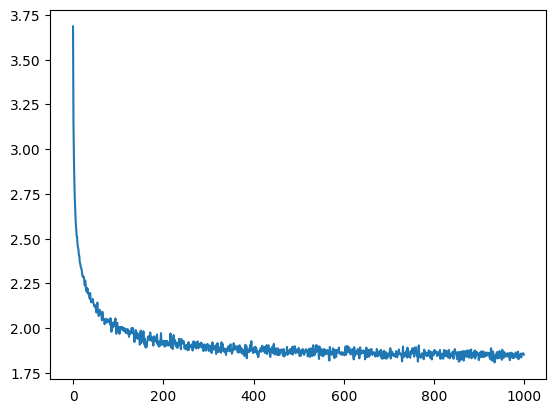

In [13]:
plt.figure()
plt.plot(all_losses)

### Оценка качества модели, генерация текста

In [14]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    
    if seed_phrase is not None:
        x_sequence = [token_to_idx["<sos>"]] + [token_to_idx[token] for token in seed_phrase.lower()]
    else:
        x_sequence = [token_to_idx["<sos>"]]
    
    prediction = x_sequence[1:]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64).view(1,-1).to(device)
    hidden = None
    
    # Восстановление вектора скрытого состояния по заданной последовательности
    if seed_phrase is not None:
        _, hidden = char_rnn(x_sequence[:,:-1], hidden)
        inp = x_sequence[:,-1].view(1,-1)
    else:
        inp = x_sequence
    
    # Начало генерации
    for p in range(max_length+1 if seed_phrase is None else max_length - len(seed_phrase)):
        output, hidden = char_rnn(inp, hidden)
        
        # Получаем вероятности индексов с учетом температуры
        p_next = nn.functional.softmax(output.view(1,-1) / temperature, dim=-1).to('cpu').data.numpy()[0]
        
        # Получаем предсказанный токен
        next_ix = np.random.choice(len(tokens), p=p_next)
        prediction.append(next_ix)
        
        # Используем предсказанный токен как вход модели
        inp = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        

    return "".join([tokens[ix] for ix in prediction])

Сгенерируем обученной сетью последовательность. Видно, что результат лишь отдаленно напоминает стихотворный текст, а при уменьшении температуры переходит в прозу.

In [15]:
print(generate_sample(rnn_model, max_length=300, temperature=1))

й
престыме.
я ожал…
никаданье в плещел;
в колные сохорь с ужинит не подъежий марин хреги, чтоб свете
в ним ни нрый дохорь
у злосла,
где дол
и изпереверленно громалисивогу счажал нежну шеще поспетами,
кростью да читал сне? вдреми в деревнуж талый заит, моя
меня поспей
иные,
стыхать санучень усно было 


### Обучение LSTM

Теперь опробуем LSTM, которая должна показать себя чуть лучше.

In [16]:
class LSTM(RNN):
    def __init__(self, input_size, hidden_size, embedding_size=18, dropout=0.0, n_layers=1):
        super().__init__(input_size, hidden_size, embedding_size, n_layers)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

Для новой модели оптимальные параметры гиперпараметры могут быть другими:

In [17]:
batch_size = 64         # Размер батча
seq_length=50           # Длина строки в батче

n_epochs = 10000
embedding_size = 25
hidden_size = 128
n_layers = 1
lr = 0.005

plot_every = 10         # Для графика loss(epoch)
print_every = 1000      

lstm_model = LSTM(num_tokens, hidden_size, embedding_size, n_layers).to(device)     # Создаем LSTM
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss(reduction='mean')

start = time.time()
all_losses = []
loss_avg = 0

# Обучение классической модели
for epoch in range(1, n_epochs + 1):
    train_feat, train_targ = random_training_set(batch_size, seq_length)
    loss = train(lstm_model, optimizer, loss_fn, train_feat.to(device), train_targ.to(device))       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[Epoch %d: %d%% | %s | loss %.4f]' % (epoch, epoch / n_epochs * 100, time_since(start), loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/home/canne16/.local/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1
  warnings.warn(


[Epoch 1000: 10% | 0m 8s | loss 1.8000]
[Epoch 2000: 20% | 0m 17s | loss 1.7761]
[Epoch 3000: 30% | 0m 26s | loss 1.6429]
[Epoch 4000: 40% | 0m 35s | loss 1.4722]
[Epoch 5000: 50% | 0m 44s | loss 1.4535]
[Epoch 6000: 60% | 0m 53s | loss 1.5416]
[Epoch 7000: 70% | 1m 2s | loss 1.4262]
[Epoch 8000: 80% | 1m 11s | loss 1.3557]
[Epoch 9000: 90% | 1m 20s | loss 1.4145]
[Epoch 10000: 100% | 1m 29s | loss 1.3716]


Построим график функции потерь от номера эпохи: видно, что он выходит на плато `loss ~ 1.4`, что несколько лучше Vanilla RNN.

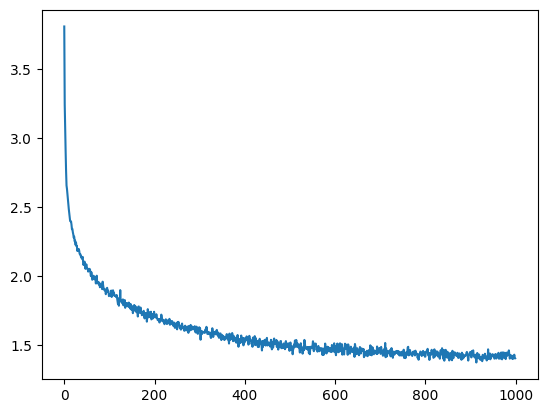

In [18]:
plt.figure()
plt.plot(all_losses)

Оценим предсказания `LSTM` для разного параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

In [19]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'\n---------------------\nGENERATED WITH t = {t}')
    print(generate_sample(lstm_model, max_length=200, temperature=t))


---------------------
GENERATED WITH t = 0.1
 вечерной томим,
и в самом в своей разделась;
прочил он всё прочел и верный
с оголь от сердце в том сохнуть,
и в сердце в нем сердце гордый на совсем
всё такогда бы жизнь мой одевенный
и в сердце он на

---------------------
GENERATED WITH t = 0.2
 на свете,
одно скости вечера своим.



xxxiii

она своей забыли друга
меж и то в том уверен,
что в этом приносят – и видин,
и в саму приятный взгляд,
и вот уж она забыла;
в том своей роднем мой одочно

---------------------
GENERATED WITH t = 0.5
, и веселый муза
от душу привету помнять из.
об явился ль он из верхой,
а мой думал молча всё уность
в том со всех перед ней.



xxxi

в сей он разутной душою,
татьяна свете, и вет.
столь утомить вечер

---------------------
GENERATED WITH t = 1.0
и здесь…
под над согнает уже молько.



xii

что собрандым чувство корда,
молько жду выводит рой стухну погулал
и он нет ни конялисяетьсь;
как лона: волненье, искре,
я мог дней и вдруг друг ли
ва в том

-------

По форме текст значительно больше походит на стихотворение. C увеличением температуры сгенерированный текст становится более разнообразным, но при этом в какой-то момент совсем непохожим на стихотворение. LSTM справилась с задачей в разы лучше классической рекуррентной нейронной сети.

### Сохранение моделей

Сохраним обученные `Vanilla RNN` и `LSTM`, а затем проверим, что всё сделали правильно:

In [20]:
torch.save(rnn_model, 'rnn.model')
torch.save(lstm_model, 'lstm.model')

In [21]:
model = torch.load('lstm.model', weights_only=False)

In [27]:
print(generate_sample(model, max_length=200, temperature=0.7))

 наш онегин в старина;
томью ужал с какие сердце вновь
под этот уж видной скорой
унадаем он друга,
что не хочешь ли явита
мне печали хладнокровно,
ели страдает воспоминанье
девочки ворот венец, и хлева
